# charts.ipynb

This notebook generates figures that track the fluctuation in various HbA1c measures during the COVID-19 pandemic.

In [54]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None

## Data Import and Cleaning

In [36]:
fpath = "../output/data"

In [37]:
# Create total dataframes
df_total = pd.read_csv(f"{fpath}/measure_total_tests_by_dm.csv", index_col=0).drop(columns=['value'])
df_gt48_dm = pd.read_csv(f"{fpath}/measure_tests_gt48_by_dm.csv", index_col=0).drop(columns=['value','population'])
df_gt58_dm = pd.read_csv(f"{fpath}/measure_tests_gt58_by_dm.csv", index_col=0).drop(columns=['value','population'])
df_gt64_dm = pd.read_csv(f"{fpath}/measure_tests_gt64_by_dm.csv", index_col=0).drop(columns=['value','population'])
df_gt75_dm = pd.read_csv(f"{fpath}/measure_tests_gt75_by_dm.csv", index_col=0).drop(columns=['value','population'])
base_dfs = [df_total, df_gt48_dm, df_gt58_dm, df_gt64_dm, df_gt75_dm]

In [38]:
df_total = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date']), base_dfs)
df_total['date'] = df_total['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
df_total_nodm = df_total.loc[df_total.diabetes_type == 'NO_DM']
df_total_t1dm = df_total.loc[df_total.diabetes_type == 'T1DM']
df_total_t2dm = df_total.loc[df_total.diabetes_type == 'T2DM']

In [39]:
# Recode variables
dict_eth = {1: 'White', 2: 'Mixed', 3: 'Asian',
            4: 'Black', 5: 'Other', np.nan: 'Unknown',
            0: 'Unknown'}

dict_imd = {0: 'Unknown', 1: '1 Most deprived', 2: '2',
            3: '3', 4: '4', 5: '5 Least deprived'}

dict_ld = {1:'Yes', 0:'No'}

In [40]:
# Create lists of dataframes broken down by demographics
def create_subdf(th):
    demos = ['age', 'sex', 'ethnicity', 'region', 'imd', 'ld', 'mi']
    li_df = []
    li_df_t1dm = []
    li_df_t2dm = []
    for d in demos:
        df_all = pd.read_csv(f"{fpath}/measure_{th}_by_dm_and_{d}.csv")
        df_all['tests_per_1000'] = df_all['value']*1000
        df_all['date'] = df_all['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
        
        if d == 'age':
            df_all = df_all.loc[df_all.age_group != '0-15']
        
        if d == 'ethnicity':
            # Format ethnicity
            df_all = df_all.replace({"ethnicity": dict_eth})
            
        if d == 'imd':
            # Format IMD 
            df_all = df_all.replace({'imd': dict_imd})
        
        if d == 'ld':
            # Format learning disability label
            df_all = df_all.replace({'learning_disability': dict_ld})
        
        df_nodm = df_all.loc[df_all.diabetes_type == 'NO_DM']
        df_t1dm = df_all.loc[df_all.diabetes_type == 'T1DM']
        df_t2dm = df_all.loc[df_all.diabetes_type == 'T2DM']
        li_df.append(df_nodm)
        li_df_t1dm.append(df_t1dm)
        li_df_t2dm.append(df_t2dm)
   
    return li_df, li_df_t1dm, li_df_t2dm

li_df, li_df_t1dm, li_df_t2dm = create_subdf('total_tests')
li_df_gt48, li_df_t1dm_gt48, li_df_t2dm_gt48 = create_subdf('tests_gt48')
li_df_gt58, li_df_t1dm_gt58, li_df_t2dm_gt58 = create_subdf('tests_gt58')
li_df_gt64, li_df_t1dm_gt64, li_df_t2dm_gt64 = create_subdf('tests_gt64')
li_df_gt75, li_df_t1dm_gt75, li_df_t2dm_gt75 = create_subdf('tests_gt75')

In [41]:
# Create percentage of tests by threshold    
def create_pct(df_in, var):
    df_in[var + '_pct'] = (df_in[var]/df_in['took_hba1c'])*100

In [42]:
thresholds = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']
for t in thresholds:
    create_pct(df_total_nodm, t)
    create_pct(df_total_t1dm, t)
    create_pct(df_total_t2dm, t)

In [43]:
# Concatenate thresholds by demographics for patients with T2DM
drop_col = ['population','value','tests_per_1000']
demo_vars = ['age_group', 'sex', 'ethnicity', 'region', 'imd', 'learning_disability', 'mental_illness']

df_thresholds = []
for i in range(0,len(li_df)):
    dfs = []
    dfs.append(li_df_t2dm[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt48[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt58[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt64[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt75[i].drop(columns=drop_col))
    df_concat = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date',demo_vars[i]]), dfs)
    for t in thresholds:
        create_pct(df_concat, t)
    df_thresholds.append(df_concat)

In [51]:
# Functions to generate charts
def create_chart(title, df, ax):
    sns.lineplot(x='date', y='value', hue='variable', ax=ax,
             data=pd.melt(df[['date','took_hba1c','hba1c_gt_48','hba1c_gt_58',
                              'hba1c_gt_64','hba1c_gt_75']], ['date']))
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    
def create_subplot(measure, group, title, df, ax):
    # Create the scatter plot
    sns.lineplot(x='date', y=measure,
                 hue=group, data=df, ax=ax)
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

def create_plotgrid(measure, dfs, ylabel, filename, title):
    fig2, axes2 = plt.subplots(4, 2, figsize=(16,24), sharex=True, sharey=True)
    fig2.delaxes(ax=axes2[3,1])

    create_subplot(measure, 'age_group', 'Age Group', 
                   dfs[0].loc[dfs[0].age_group != 'missing'], axes2[0,0])
    create_subplot(measure, 'sex', 'Sex', 
                   dfs[1].loc[dfs[1].sex.isin(['F','M'])], axes2[0,1])
    create_subplot(measure, 'ethnicity', 'Ethnicity', 
                   dfs[2], axes2[1,0])
    create_subplot(measure, 'region', 'Region', 
                   dfs[3], axes2[1,1])
    create_subplot(measure, 'imd', 'IMD', 
                   dfs[4], axes2[2,0])
    create_subplot(measure, 'learning_disability', 'Learning Disability', 
                   dfs[5], axes2[2,1])
    create_subplot(measure, 'mental_illness', 'Mental Illness', 
                   dfs[6], axes2[3,0])

    # Set axes labels
    plt.setp(axes2[-1, :],
             xlabel='Date')
    plt.setp(axes2[:, 0],
             ylabel=ylabel)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.suptitle(title, fontsize=16)
    plt.savefig('../output/' + filename + '.png')
    plt.show()

_______

## Total Number

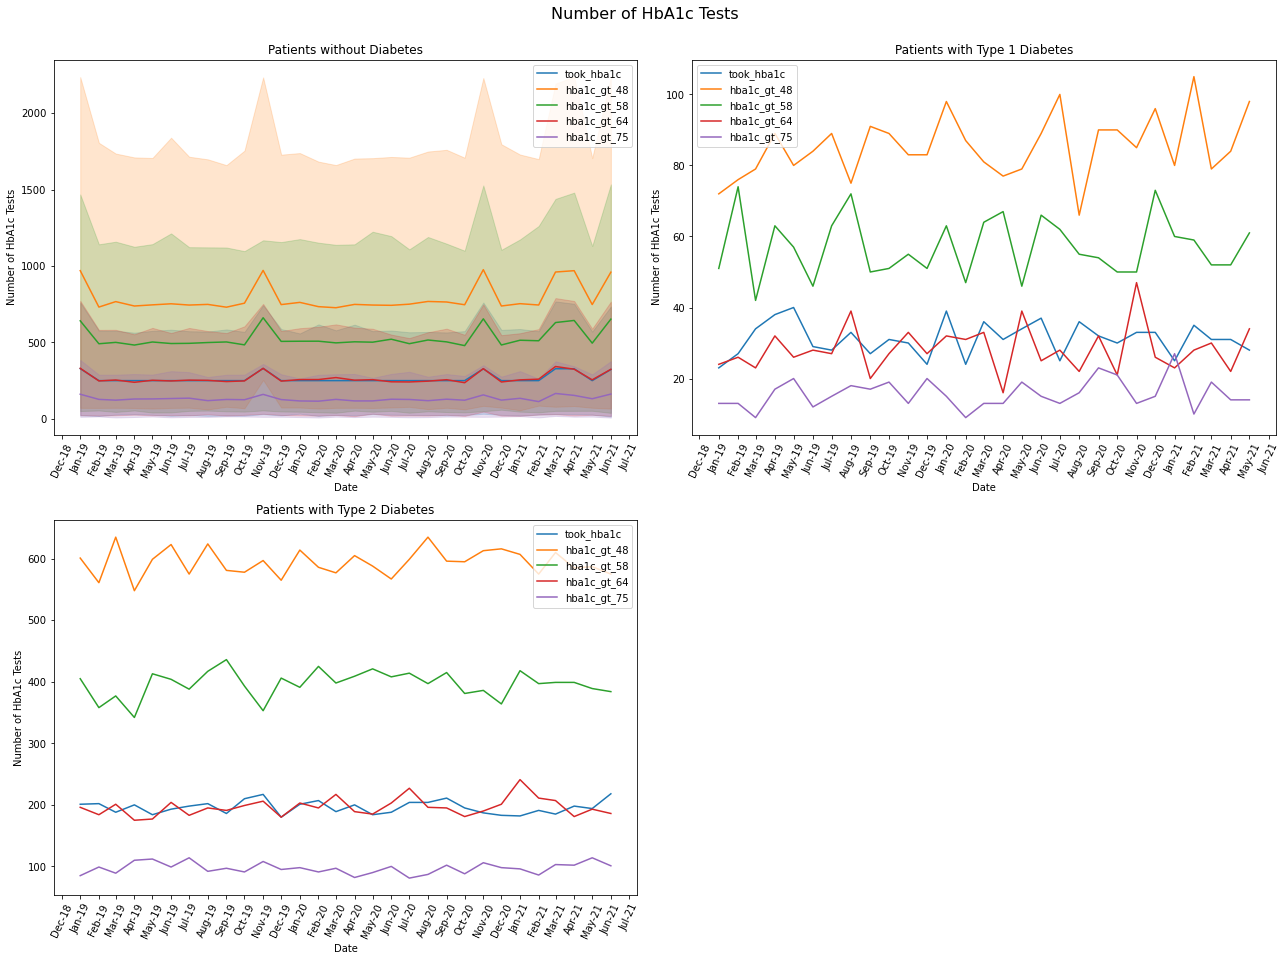

In [52]:
# Total number
fig, axes = plt.subplots(2,2, figsize=(18, 14))
fig.delaxes(ax=axes[1,1])
create_chart('Patients without Diabetes', df_total, axes[0,0])
create_chart('Patients with Type 1 Diabetes', df_total_t1dm, axes[0,1])
create_chart('Patients with Type 2 Diabetes', df_total_t2dm, axes[1,0])

fig.suptitle('Number of HbA1c Tests', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../output/total_by_dm.png')
plt.show()

## Number of Tests in Patients with Elevated HbA1c Pre-pandemic

## Number of Tests in Patients with Prediabetes Pre-pandemic